## Dataset and methodology description

The dataset focuses on gene expression levels from 7129 genes in 72 patients diagnosed with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL), derived from bone marrow and peripheral blood samples. This data comes from a study by Golub et al. in 1999, illustrating the potential of gene expression monitoring via DNA microarray for cancer classification. The dataset includes initial and independent datasets with 38 and 34 samples, respectively, aiming to classify AML and ALL patients.


The dataset underwent a preprocessing including merging train and test (since we do not need to test something here), check for null values. Last but not least, recognizing the importance of normalization for the performance of statistical tests (as many machine learning models), we scaled the data as an additional improvement step to ensure optimal analysis conditions.

For the analysis, a straightforward but illustrative methodology is adopted. Initially, t-tests are used to identify key genes that significantly contribute to distinguishing between AML and ALL. This step is crucial because it helps in pinpointing specific genes relevant for classification and potential targeted treatments. Additionally, we will compare the original p-values obtained from the t-tests with those corrected for false discovery rate (FDR) to account for multiple testing issues and ensure the reliability of our findings in identifying significant genes. This comparison is essential for refining the selection of gene features that are truly significant in differentiating between AML and ALL.

## Data preprocessing

### Load all the required libraries

In [10]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler



def save_pyplot_figure(fig, filename):
    """
    Saves a Matplotlib figure to a file.
    """
    # Save the figure using the provided filename
    fig.savefig(filename)
    print(f"Figure saved as {filename}")

### Load data

In [2]:
# Loading training dataset
df_train = pd.read_csv('data/kaggle_GE_data/data_set_ALL_AML_train.csv')
df_test = pd.read_csv('data/kaggle_GE_data/data_set_ALL_AML_independent.csv')
labels = pd.read_csv('data/kaggle_GE_data/actual.csv')

display(df_train.head(3))
display(df_test.head(3))
display(labels.head(3))

print(df_train.shape)
print(df_test.shape)
print(labels.shape)

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A


,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL


(7129, 78)
(7129, 70)
(72, 2)


### Cleaning data

- Delete 'call' columns: we do not need them for the current experiment -- it is not counts of genes
- Transpose the columns and rows: 7129 genes become features, and each patient - single row.
- Clean and drop namings cols (it is not really matter for our purposes)
- Convert data values to numeric.

In [3]:
# Remove call columns
columns_to_remove_train = [col for col in df_train if 'call' in col]
train = df_train.drop(columns_to_remove_train, axis=1)
columns_to_remove_test = [col for col in df_test if 'call' in col]
test = df_test.drop(columns_to_remove_test, axis=1)

# Transpose
X_train = train.T
X_test = test.T

# Cleaning stuff
X_train.columns = X_train.iloc[1] 
X_test.columns = X_test.iloc[1]
X_train = X_train.iloc[2:].reset_index(drop=True)
X_test = X_test.iloc[2:].reset_index(drop=True)

# To numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')




### Concating data

- merge training set, testing set, and labels
- check for nulls (there is no nulls in our data)
- Replace values in the 'cancer' column with 0 for 'ALL' and 1 for 'AML'

In [4]:
# Merge all dataset
merged_X = pd.concat([X_train, X_test], ignore_index=True, axis=0)
merged_XY = pd.concat([merged_X, labels], axis=1)

# Check for nulls
null_counts = merged_XY.isnull().sum().max()
print('Columns with Null Values:')
print(null_counts)

# Replace values to 0/1
cancer_mapping = {'ALL': 0, 'AML': 1}
merged_XY['cancer'] = merged_XY['cancer'].map(cancer_mapping)

print(merged_XY.shape)
merged_XY.head()

Columns with Null Values:
0
(72, 7131)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,0


### Additional improvings
- t-tests (as many ML models) perform better with normalized data => scale the data

In [6]:
# Exclude patient and cancer columns
gene_columns = merged_XY.columns.drop(["patient", "cancer"])
merged_X = merged_X[gene_columns]

# Scaling __all expression data__
normalized_merged_X = pd.DataFrame(
    StandardScaler().fit(merged_X).transform(merged_X), columns=gene_columns
)
normalized_merged_X_ALL = normalized_merged_X[merged_XY["cancer"] == 0]
normalized_merged_X_AML = normalized_merged_X[merged_XY["cancer"] == 1]

print(normalized_merged_X_ALL.shape)
print(normalized_merged_X_AML.shape)

(47, 7129)
(25, 7129)


## ***Statistical analysis of gene expression using t-test*** <a class="anchor"  id="t_test"></a>

- Goal: identify genes that play a role in distinguishing between ALL and AML. 
- Therefore we need to select genes where there is a significant difference between the means of the two groups. 
- T-test is a commonly used statistical test for this purpose: the p-value indicates the statistical significance of the result. 
- Typically: threshold for p-values is 0.05. Motivation: a p-value lower than 0.05 means that the probability of obtaining such a difference between the two groups by chance is less than 5%, providing strong evidence to confirm the result.

### T-test

In [7]:
# Perform t-test for each gene
results = []
for gene in normalized_merged_X_ALL.columns:
    t_value, p_value = ttest_ind(normalized_merged_X_ALL[gene], normalized_merged_X_AML[gene], equal_var=False)
    results.append((gene, t_value, p_value))

# Convert results list to DataFrame
df_results = pd.DataFrame(results, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# Adjust p-values for multiple testing using False Discovery Rate (FDR) correction
rejected, adjusted_p_values = fdrcorrection(df_results['P_Value'])

Let's compare these pvals:

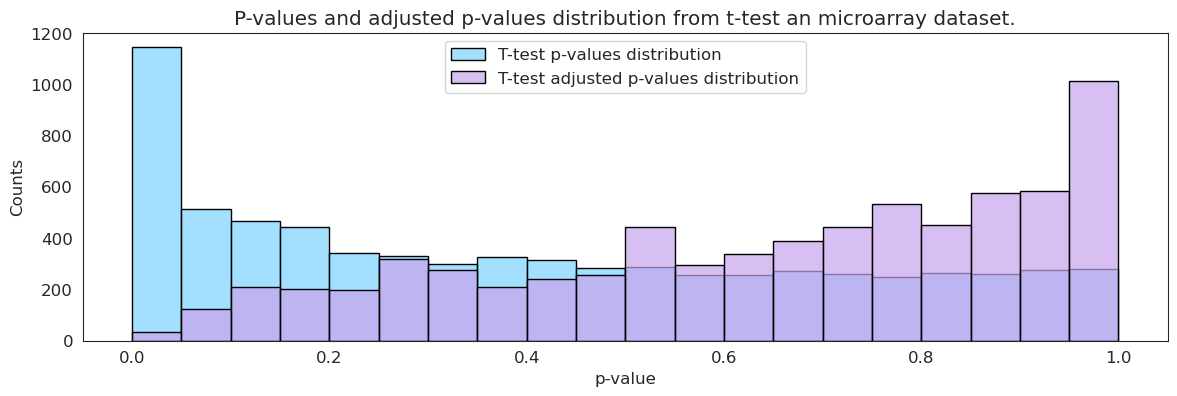

Figure saved as figures/F3.png


In [22]:
plt.rcParams.update({'font.size': 12})
f = plt.figure(figsize=(14, 4))

sns.set_style("white")
sns.set_palette("pastel")

sns.histplot(
    df_results["P_Value"].to_numpy(),
    bins=[i/20 for i in range(0,21)],
    label="T-test p-values distribution",
    color="#7dd3ff",
    edgecolor='black',
    alpha=0.7,
)
sns.histplot(
    adjusted_p_values,
    bins=[i/20 for i in range(0,21)],
    label="T-test adjusted p-values distribution",
    color="#c7a4ed",
    edgecolor='black',
    alpha=0.7,
)

plt.xlabel("p-value")
plt.ylabel("Counts")
plt.title("P-values and adjusted p-values distribution from t-test an microarray dataset.")
plt.legend()  # Adding the legend
plt.show()
save_pyplot_figure(f, "figures/F3.png")

In [9]:
print(f'Total amount of genes: {len(df_results)}')
print(f'Significant with p-value cut-off threshold 0.05: {sum(df_results.P_Value<0.05)}')
print(f'Significant with adjusted p-value cut-off threshold 0.05: {sum(adjusted_p_values<0.05)}')

Total amount of genes: 7129
Significant with p-value cut-off threshold 0.05: 1144
Significant with adjusted p-value cut-off threshold 0.05: 34


## Reference
Golub, T. R., Slonim, D. K., Tamayo, P., Huard, C., Gaasenbeek, M., Mesirov, J. P., Coller, H., Loh, M. L., Downing, J. R., Caligiuri, M. A., Bloomfield, C. D., & Lander, E. S. (1999). Molecular classification of cancer: Class Discovery and class prediction by Gene Expression Monitoring. Science, 286(5439), 531–537. https://doi.org/10.1126/science.286.5439.531

Crawford, C. (2017, August 8). Gene expression dataset (golub et al..). Kaggle. https://www.kaggle.com/datasets/crawford/gene-expression/code?datasetId=1868&sortBy=voteCount